# A Network Tour of Data Science

[Michaël Defferrard](http://deff.ch), *PhD student*, [Pierre Vandergheynst](https://people.epfl.ch/pierre.vandergheynst), *Full Professor*, [EPFL](http://epfl.ch) [LTS2](http://lts2.epfl.ch).

# Assignment 4: Transductive Learning using Graphs

Transduction is reasoning from observed, specific (training) cases to specific (test) cases. For this assignment, the task is to infer missing values in some dataset, while the training and testing cases are available to construct a graph. The exercise consists of two parts: (1) construct some artificial data and (2) retrieve the missing values and measure performance.

## 1 Smooth graph signal

Let $\mathcal{G} = (\mathcal{V}, W)$ be a graph of vertex set $\mathcal{V}$ and weighted adjacency matrix $W$.

N = |V| = 100, k|V| < |E| = 1176


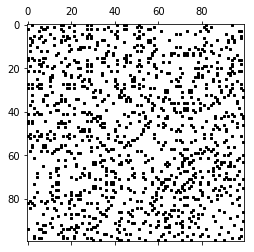

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline
import os.path

X = scipy.io.mmread(os.path.join('datasets', 'graph_inpainting', 'embedding.mtx'))
W = scipy.io.mmread(os.path.join('datasets', 'graph_inpainting', 'graph.mtx'))
N = W.shape[0]

print('N = |V| = {}, k|V| < |E| = {}'.format(N, W.nnz))
plt.spy(W, markersize=2, color='black');

Design a technique to construct smooth scalar signals $x \in \mathbb{R}^N$ over the graph $\mathcal{G}$.

Hint:
* This part is related to our [last exercise](07_ex_graph_fourier.ipynb).
* There is multiple ways to do this, another is to filter random signals.

M = x^T L x = 0.2593619731204485


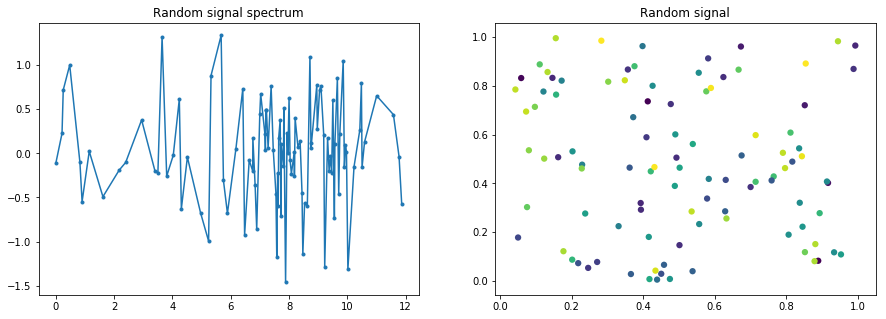

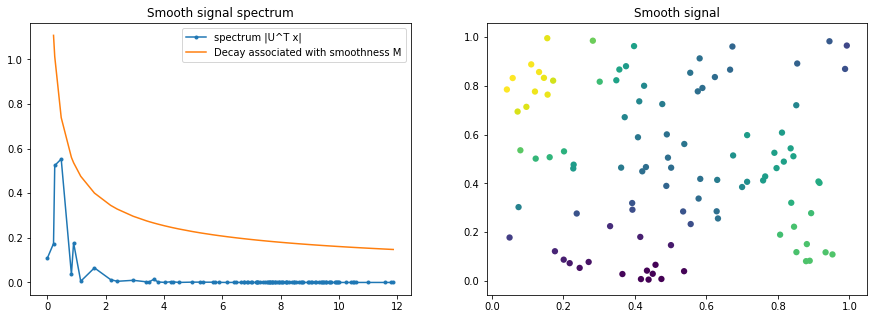

In [2]:
# Fourier basis.
D = W.sum(axis=0)
D = scipy.sparse.diags(D.A.squeeze(), 0)
L = D - W
lamb, U = np.linalg.eigh(L.toarray())

# Low-pass filters.

def f1(u, a=4):
    y = np.zeros(u.shape)
    y[:a] = 1
    return y
def f2(u, m=4):
    return np.maximum(1 - m * u / u[-1], 0)
def f3(u, a=0.8):
    return np.exp(-u / a)

# Random signal.
x = np.random.uniform(-1, 1, size=W.shape[0])
xhat = U.T.dot(x)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(lamb, xhat, '.-')
ax[0].set_title('Random signal spectrum')
ax[1].scatter(X[:, 0], X[:, 1], c=x, s=40, linewidths=0)
ax[1].set_title('Random signal')

# Smooth signal through filtering.
xhat *= f3(lamb)
x = U.dot(xhat)

M = x.T.dot(L.dot(x))
print('M = x^T L x = {}'.format(M))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Smooth signal spectrum')
ax[0].plot(lamb, abs(xhat), '.-', label='spectrum |U^T x|')
#ax[0].plot(lamb, np.sqrt(M/lamb))
ax[0].plot(lamb[1:], np.sqrt(M/lamb[1:]), label='Decay associated with smoothness M')
ax[0].legend()
ax[1].scatter(X[:, 0], X[:, 1], c=x, s=40, linewidths=0)
ax[1].set_title('Smooth signal');

## 2 Graph Signal Inpainting

Let $y$ be a signal obtained by observing $n$ out the $N$ entries of a smooth signal $x$. Design and implement a procedure to infer the missing values and test its average accuracy $\| x^\ast - x \|_2^2$ as a function of $n/N$ on a test set of signals created using the technique developed above.

First complete the equations below, then do the implementation.

Observation:
$$y = Ax$$
where $A$ is a diagonal masking matrix with $\operatorname{diag(A)} \in \{0,1\}^N$.

Optimization problem:
$$x^\ast = \operatorname{arg } \min_x \frac{\tau}{2} \|Ax - y\|_2^2 + \frac12 x^T L x$$
where $\|Ax - y\|_2^2$ is the fidelity term and 
$x^T L x = \sum_{u \sim v} w(u,v) (x(u) - x(v))^2$ is the smoothness prior.

Optimal solution (by putting the derivative to zero):
$$\tau Ax^\ast - \tau y + L x^\ast = 0
\hspace{0.3cm} \rightarrow \hspace{0.3cm}
x^\ast = (\tau A + L)^{-1} \tau y$$

Hint: in the end the solution should be a linear system of equations, to be solved with `np.linalg.solve()`.

|x-y|_2^2 = 0.314506
|x-x*|_2^2 = 0.025536


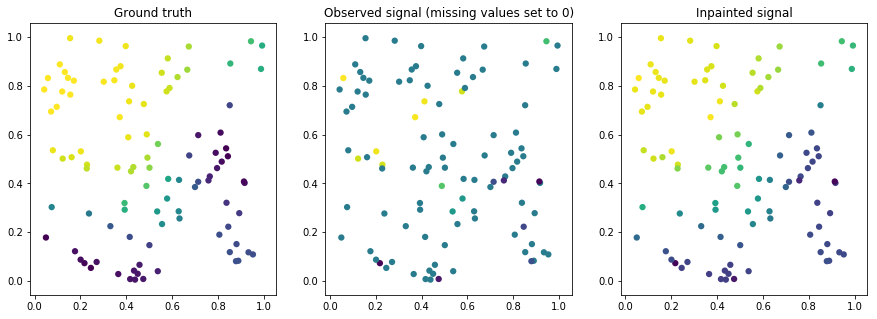

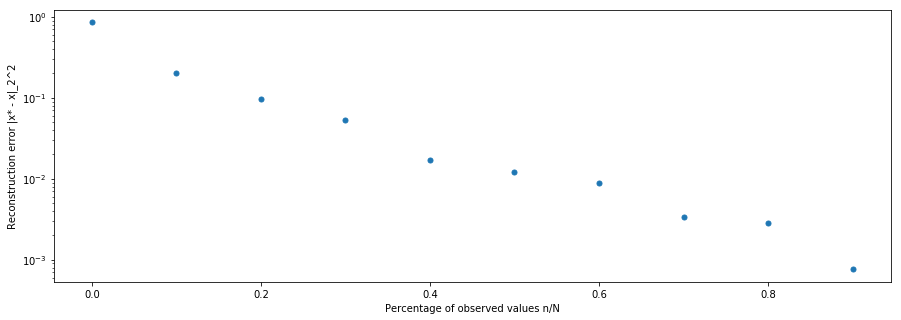

In [3]:
tau = 1e5  # Balance between fidelity and smoothness prior.
num = 100  # Number of signals and masks to generate.

# Percentage of values to keep.
probs = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0, 0.1, 0.2, 0.3]

errors = []
for p in probs:
    mse = 0
    for _ in range(num):
        # Smooth signal.
        x = np.random.uniform(-1, 1, size=W.shape[0])
        xhat = U.T.dot(x) * f3(lamb)
        x = U.dot(xhat)

        # Observation.
        A = np.diag(np.random.uniform(size=N) < p)
        y = A.dot(x)

        # Reconstruction.
        x_sol = np.linalg.solve(tau * A + L, tau * y)
        mse += np.linalg.norm(x - x_sol)**2
    errors.append(mse / num)

# Show one example.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
param = dict(s=40, vmin=min(x), vmax=max(x), linewidths=0)
ax[0].scatter(X[:, 0], X[:, 1], c=x, **param)
ax[1].scatter(X[:, 0], X[:, 1], c=y, **param)
ax[2].scatter(X[:, 0], X[:, 1], c=x_sol, **param)
ax[0].set_title('Ground truth')
ax[1].set_title('Observed signal (missing values set to 0)')
ax[2].set_title('Inpainted signal')

print('|x-y|_2^2 = {:5f}'.format(np.linalg.norm(x - y)**2))
print('|x-x*|_2^2 = {:5f}'.format(np.linalg.norm(x - x_sol)**2))

# Show reconstruction error w.r.t. percentage of observed values.
plt.figure(figsize=(15, 5))
plt.semilogy(probs, errors, '.', markersize=10)
plt.xlabel('Percentage of observed values n/N')
plt.ylabel('Reconstruction error |x* - x|_2^2');